# Modelos

En este notebook se probarán distintos modelos para predecir las propinas. El enfoque que se le va a dar al proyecto va a ser el siguiente:
- Modelo de clasificación. En primer lugar, se diseñará un modelo para clasificar los viajes en viajes de propinas bajas y viajes de propinas altas.
- Modelos de regresión. Tras la clasificación inicial, se diseñarán dos modelos de regresión, uno para cada clase.  

Dado que el objetivo principal es identificar el máximo posible de propinas altas ( >10$, clase 1) la métrica que se va a utilizar para evaluar los modelos es el f2-score, que aplica un coeficiente beta al f-score para asignar mas peso al recall en comparación con la precisión


In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Machine learning supervisado
# ==============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn import svm
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, make_scorer, recall_score, precision_score
import xgboost

# Transformación logarítmica
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Guardar modelos
# ==============================================================================
import pickle


### Carga de datos

In [2]:
df = pd.read_csv('../../data/df_yellowtaxi_cleaned.csv', index_col='Unnamed: 0')
df_zones = pd.read_csv('../../data/taxi_zone_geo.csv')

In [3]:
df.head()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,congestion_surcharge,Airport_fee,pickup_DoW,pickup_DoW_name,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h),tolls_percentage,tip_amount
1,2.0,3.76506,1.0,236,233,1,14.2,True,2.5,0.00,4,Friday,00:18:40,0,708.0,11.898305,0.0,2.00
2,1.0,2.60658,1.0,162,236,1,8.6,True,2.5,0.00,4,Friday,00:35:01,0,243.0,24.000000,0.0,2.00
4,1.0,15.84865,1.0,138,230,1,45.0,True,2.5,1.75,4,Friday,00:01:23,0,2202.0,16.103542,0.0,17.02
7,1.0,6.27510,1.0,140,7,1,20.5,True,2.5,0.00,4,Friday,00:01:04,0,1052.0,13.346008,0.0,6.35
8,2.0,4.34430,1.0,45,164,1,16.3,True,2.5,0.00,4,Friday,00:37:44,0,880.0,11.045455,0.0,4.26


Se crea la variable tip_per_km a partir de la cantidad de propina y la distancia del recorrido


In [4]:
df['tip_per_km'] = df['tip_amount'] / df['trip_distance']
df['tip_per_km'].describe().round(2)

count    1959279.00
mean           1.14
std            0.78
min            0.00
25%            0.67
50%            1.06
75%            1.51
max          159.36
Name: tip_per_km, dtype: float64

In [5]:
limite = 2
print('Propinas normales: ', df['tip_per_km'][df['tip_per_km']<limite].shape[0])
print('Propinas generosas: ', df['tip_per_km'][df['tip_per_km']>=limite].shape[0])

Propinas normales:  1768128
Propinas generosas:  191151


In [6]:
# creamos las dos categorias: Propinas generosas si tip_per_km es >=2 o normales si son < 2
df['tip_km_category'] = [1 if x >= 2 else 0 for x in df['tip_per_km'] ]

Para este modelo, se va a realizar un target encoding de las variable PULocationID y DOLocationID, asignando a cada zona la media, aplicandoun suavizado, que ayuda a evitar que las zonas con pocos datos (es decir, con pocas observaciones) tengan medias poco confiables o extremas.    
Para zonas con pocos viajes, las medias extremas se moderan acercándolas a la media global.
Para zonas con suficientes viajes, las medias se mantienen similares a las medias observadas en los datos.

In [7]:
# Factor de suavizado
m = 20  

# Media global de propinas
global_avg_tip = df['tip_amount'].mean()

# Calcular la media por zona y el número de registros por zona
zone_stats = df.groupby('PULocationID')['tip_amount'].agg(
    avg_tip= 'mean',  # Propina media
    count='count'  # Número de registros
).reset_index()

# Aplicar el suavizado
zone_stats['smoothed_avg_tip'] = (
    (zone_stats['count'] * zone_stats['avg_tip'] + m * global_avg_tip) /
    (zone_stats['count'] + m)
)

# Mapear el porcentaje suavizado a la columna original
df['PULocationEncoded'] = df['PULocationID'].map(zone_stats.set_index('PULocationID')['smoothed_avg_tip'])
df.head()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,congestion_surcharge,Airport_fee,...,pickup_DoW_name,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h),tolls_percentage,tip_amount,tip_per_km,tip_km_category,PULocationEncoded
1,2.0,3.76506,1.0,236,233,1,14.2,True,2.5,0.00,...,Friday,00:18:40,0,708.0,11.898305,0.0,2.00,0.531200,0,3.525706
2,1.0,2.60658,1.0,162,236,1,8.6,True,2.5,0.00,...,Friday,00:35:01,0,243.0,24.000000,0.0,2.00,0.767289,0,4.046324
4,1.0,15.84865,1.0,138,230,1,45.0,True,2.5,1.75,...,Friday,00:01:23,0,2202.0,16.103542,0.0,17.02,1.073909,0,10.387664
7,1.0,6.27510,1.0,140,7,1,20.5,True,2.5,0.00,...,Friday,00:01:04,0,1052.0,13.346008,0.0,6.35,1.011936,0,3.720870
8,2.0,4.34430,1.0,45,164,1,16.3,True,2.5,0.00,...,Friday,00:37:44,0,880.0,11.045455,0.0,4.26,0.980595,0,4.401401


In [8]:
# Se aplica el mismo procedimiento para las ubicaciones de dropoff:
# Factor de suavizado
m = 20  

# Media global de propinas
global_avg_tip = df['tip_amount'].mean()

# Calcular la media por zona y el número de registros por zona
zone_stats = df.groupby('DOLocationID')['tip_amount'].agg(
    avg_tip= 'mean',  # Propina media
    count='count'  # Número de registros
).reset_index()

# Aplicar el suavizado
zone_stats['smoothed_avg_tip'] = (
    (zone_stats['count'] * zone_stats['avg_tip'] + m * global_avg_tip) /
    (zone_stats['count'] + m)
)

# Mapear el porcentaje suavizado a la columna original
df['DOLocationEncoded'] = df['DOLocationID'].map(zone_stats.set_index('DOLocationID')['smoothed_avg_tip'])
df.head()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,congestion_surcharge,Airport_fee,...,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h),tolls_percentage,tip_amount,tip_per_km,tip_km_category,PULocationEncoded,DOLocationEncoded
1,2.0,3.76506,1.0,236,233,1,14.2,True,2.5,0.00,...,00:18:40,0,708.0,11.898305,0.0,2.00,0.531200,0,3.525706,4.114556
2,1.0,2.60658,1.0,162,236,1,8.6,True,2.5,0.00,...,00:35:01,0,243.0,24.000000,0.0,2.00,0.767289,0,4.046324,3.681914
4,1.0,15.84865,1.0,138,230,1,45.0,True,2.5,1.75,...,00:01:23,0,2202.0,16.103542,0.0,17.02,1.073909,0,10.387664,5.546674
7,1.0,6.27510,1.0,140,7,1,20.5,True,2.5,0.00,...,00:01:04,0,1052.0,13.346008,0.0,6.35,1.011936,0,3.720870,6.092011
8,2.0,4.34430,1.0,45,164,1,16.3,True,2.5,0.00,...,00:37:44,0,880.0,11.045455,0.0,4.26,0.980595,0,4.401401,4.787478


In [9]:
# Eliminamos del df las columnas DOLocationID y PULocationID
df = df.drop(columns = ['DOLocationID', 'PULocationID'])

 Como el dataset tiene una gran cantidad de datos, se va a realizar un muestreo para reducir el tiempo de entrenamiento de los modelos y agilizar el trabajo. El target está muy desbalanceado (aprox 90% clase 0 vs 10% clase 1), por lo tanto se va a realizar un submuestreo únicamente a la clase 0, para tener una representación más parecida de las dos clases

In [10]:
# Separar las clases
class_0 = df[df['tip_km_category'] == 0]
class_1 = df[df['tip_km_category'] == 1]

# Submuestreo de la clase mayoritaria
class_0_sampled = class_0.sample(n=int(0.2*len(class_0)), random_state=42)

# Combinar las clases y mezclar
balanced_df = pd.concat([class_0_sampled, class_1]).sample(frac=1, random_state=42)     # con el .sample se mezclan las filas para que no queden ordenadas, ya que al hacer merge quedaron primero todas las de una categoría y luego las de la otra

# Redefinir X e y
X = balanced_df.drop(columns=['tip_per_km','RatecodeID', 'payment_type', 'mta_tax', 'pickup_Timestamp', 'pickup_DoW_name', 'tip_km_category', 'tip_amount'])
y = balanced_df['tip_km_category']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
# Crear el pipeline con XGBClassifier
pipe = Pipeline(steps=[
    ('classifier', xgboost.XGBClassifier())
])

# Definir el espacio de búsqueda para XGBClassifier
xgboost_param = {
    'classifier__n_estimators': [200, 300],  # Número de árboles
    'classifier__learning_rate': [0.01, 0.03, 0.05],  # Tasa de aprendizaje
    'classifier__max_depth': [3, 4]  # Profundidad máxima
}

# Espacio de búsqueda para RandomForest
random_forest_params = {
    'classifier': [RandomForestClassifier()],
    "classifier__n_estimators": [100, 150],  # Número de árboles
    'classifier__max_depth': [3,4]
}

search_space = [
    random_forest_params,
    xgboost_param,
]

# Configurar RandomizedSearchCV
clf = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=search_space,  # Espacio de búsqueda para XGBClassifier
    n_iter=10,  # Número de combinaciones a probar
    scoring=make_scorer(fbeta_score, beta=2),  # Métrica de evaluación (F2 Score)
    n_jobs=-1,  # Paralelización
    random_state=42  # Semilla para reproducibilidad
)

# Entrenar el modelo
clf.fit(X_train, y_train)

# Mostrar los mejores parámetros y modelo
print("Best Parameters:", clf.best_params_)
print("Best Model:", clf.best_estimator_)

# Evaluar en el conjunto de entrenamiento
y_pred_train = clf.best_estimator_.predict(X_train)
f2_train = round(fbeta_score(y_train, y_pred_train, beta=2), 3)
print("F2 Score (Train):", f2_train)

# Evaluar en el conjunto de prueba
y_pred = clf.best_estimator_.predict(X_test)
f2_test = round(fbeta_score(y_test, y_pred, beta=2), 3)
print("F2 Score (Test):", f2_test)

Best Parameters: {'classifier__n_estimators': 300, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Best Model: Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan

In [22]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     88212
           1       0.80      0.82      0.81     47982

    accuracy                           0.86    136194
   macro avg       0.85      0.85      0.85    136194
weighted avg       0.87      0.86      0.87    136194



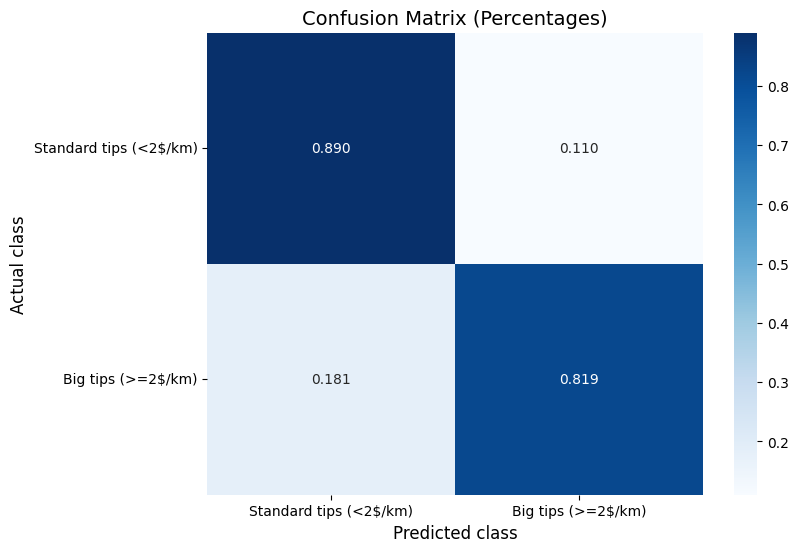

In [23]:
# Generar la matriz de confusión
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Convertir la matriz de confusión a porcentaje
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# Crear el heatmap con porcentajes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".3f", cmap="Blues", cbar=True)

# Cambiar las etiquetas
plt.xlabel('Predicted class', fontsize=12)
plt.ylabel('Actual class', fontsize=12)
plt.xticks([0.5, 1.5], ['Standard tips (<2$/km)', 'Big tips (>=2$/km)'], fontsize=10)
plt.yticks([0.5, 1.5], ['Standard tips (<2$/km)', 'Big tips (>=2$/km)'], fontsize=10, rotation=0)

# Título opcional
plt.title('Confusion Matrix (Percentages)', fontsize=14)
plt.show()

                 Feature  Importance
1          trip_distance    0.639994
8        avg_speed(km/h)    0.205731
6            pickup_Time    0.058159
5             pickup_DoW    0.037949
2            fare_amount    0.033741
3   congestion_surcharge    0.011693
7          trip_duration    0.007111
10     PULocationEncoded    0.005622
0        passenger_count    0.000000
4            Airport_fee    0.000000
9       tolls_percentage    0.000000
11     DOLocationEncoded    0.000000


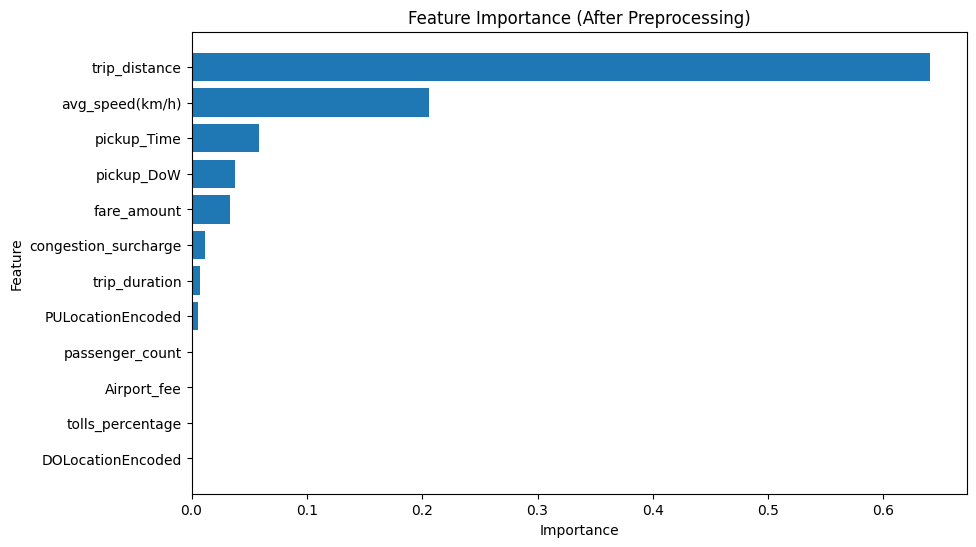

In [24]:
classifier = clf.best_estimator_.named_steps['classifier']

# Extraer las importancias del clasificador
if hasattr(classifier, 'feature_importances_'):
    feature_importances = classifier.feature_importances_
    feature_names = X_train.columns
else:
    raise AttributeError("El clasificador no tiene el atributo 'feature_importances_'")

# Asociar las importancias con las características
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las importancias
print(importance_df)

# Visualización opcional
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [52]:
# Guardamos el modelo en un archivo con pickle
with open('classifier_6.pkl', 'wb') as file:
    pickle.dump(clf.best_estimator_, file)

print("Modelo guardado como 'classifier_6.pkl'")

Modelo guardado como 'classifier_2.pkl'


Voy a probar a ejecutar el mismo modelo eliminando algunas features que parecen no tener importancia. Passenger_count y airport_fee

In [11]:
X.drop(columns = ['passenger_count', 'Airport_fee'], inplace = True)
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
# Crear el pipeline con XGBClassifier
pipe = Pipeline(steps=[
    ('classifier', xgboost.XGBClassifier())
])

# Definir el espacio de búsqueda para XGBClassifier
xgboost_param = {
    'classifier__n_estimators': [200, 300],  # Número de árboles
    'classifier__learning_rate': [0.01, 0.03, 0.05],  # Tasa de aprendizaje
    'classifier__max_depth': [3, 4]  # Profundidad máxima
}

# Configurar RandomizedSearchCV
clf = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=xgboost_param,  # Espacio de búsqueda para XGBClassifier
    n_iter=10,  # Número de combinaciones a probar
    scoring=make_scorer(fbeta_score, beta=2),  # Métrica de evaluación (F2 Score)
    n_jobs=-1,  # Paralelización
    random_state=42  # Semilla para reproducibilidad
)

# Entrenar el modelo
clf.fit(X_train, y_train)

# Mostrar los mejores parámetros y modelo
print("Best Parameters:", clf.best_params_)
print("Best Model:", clf.best_estimator_)

# Evaluar en el conjunto de entrenamiento
y_pred_train = clf.best_estimator_.predict(X_train)
f2_train = round(fbeta_score(y_train, y_pred_train, beta=2), 3)
print("F2 Score (Train):", f2_train)

# Evaluar en el conjunto de prueba
y_pred = clf.best_estimator_.predict(X_test)
f2_test = round(fbeta_score(y_test, y_pred, beta=2), 3)
print("F2 Score (Test):", f2_test)

Best Parameters: {'classifier__n_estimators': 300, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Best Model: Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     88212
           1       0.80      0.82      0.81     47982

    accuracy                           0.86    136194
   macro avg       0.85      0.85      0.85    136194
weighted avg       0.87      0.86      0.87    136194



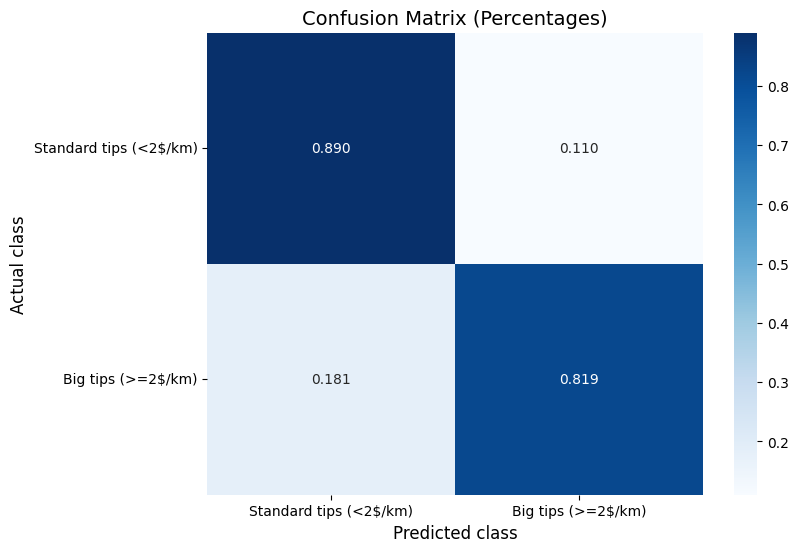

In [ ]:
# Generar la matriz de confusión
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Convertir la matriz de confusión a porcentaje
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# Crear el heatmap con porcentajes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".3f", cmap="Blues", cbar=True)

# Cambiar las etiquetas
plt.xlabel('Predicted class', fontsize=12)
plt.ylabel('Actual class', fontsize=12)
plt.xticks([0.5, 1.5], ['Standard tips (<2$/km)', 'Big tips (>=2$/km)'], fontsize=10)
plt.yticks([0.5, 1.5], ['Standard tips (<2$/km)', 'Big tips (>=2$/km)'], fontsize=10, rotation=0)

# Título opcional
plt.title('Confusion Matrix (Percentages)', fontsize=14)
plt.show()

                 Feature  Importance
1          trip_distance    0.639994
8        avg_speed(km/h)    0.205731
6            pickup_Time    0.058159
5             pickup_DoW    0.037949
2            fare_amount    0.033741
3   congestion_surcharge    0.011693
7          trip_duration    0.007111
10     PULocationEncoded    0.005622
0        passenger_count    0.000000
4            Airport_fee    0.000000
9       tolls_percentage    0.000000
11     DOLocationEncoded    0.000000


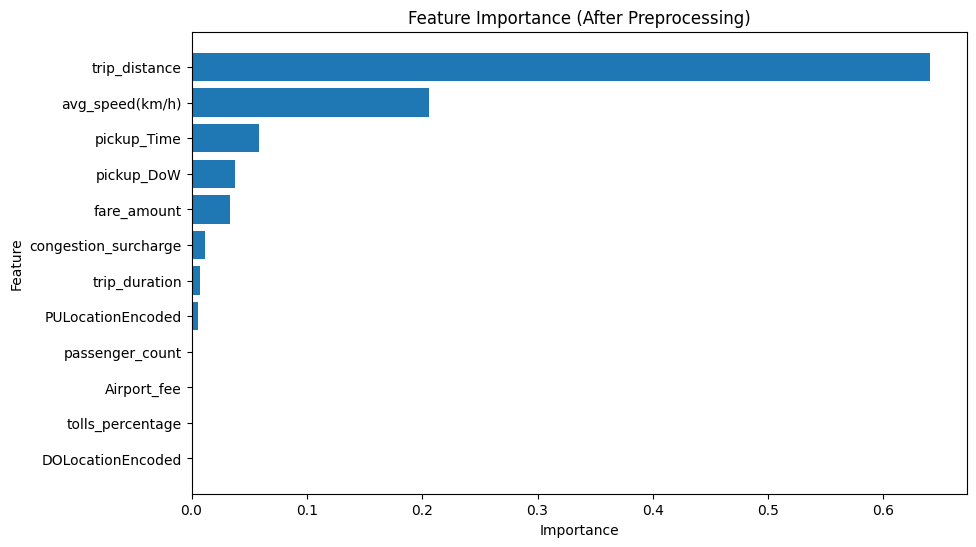

In [ ]:
classifier = clf.best_estimator_.named_steps['classifier']

# Extraer las importancias del clasificador
if hasattr(classifier, 'feature_importances_'):
    feature_importances = classifier.feature_importances_
    feature_names = X_train.columns
else:
    raise AttributeError("El clasificador no tiene el atributo 'feature_importances_'")

# Asociar las importancias con las características
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las importancias
print(importance_df)

# Visualización opcional
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
# Guardamos el modelo en un archivo con pickle
with open('classifier_6b.pkl', 'wb') as file:
    pickle.dump(clf.best_estimator_, file)

print("Modelo guardado como 'classifier_6b.pkl'")